# Vanilla ABC-SMC 
Set up requrirements and experimental data

In [44]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Jun 22 18:22:52 2020

@author: marcofking
"""


import pyabc as pyabc
from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition)
from pyabc.visualization import plot_kde_2d, plot_data_callback
import matplotlib.pyplot as plt
import os
import tempfile
import numpy as np
#import scipy as sp
from scipy.integrate import odeint
import math
import seaborn as sns
#pyabc.settings.set_figure_params('pyabc')  # for beautified plots
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test4.db"))



# Define the ODE to solve 

We consider only recontamination from surface contacts, not from additional proliferation of the bacterias on the hands.
$$ \dfrac{dy}{dt}=(1-\dfrac{y}{C} )r-d\exp(-g \quad t)y $$

Alternatively, we could consider a model with proliferation but no contacts

$$ \dfrac{dy}{dt}=L  C  \left (1-\dfrac{y}{C} \right )-d \exp(-g \quad t)y $$

Where $LC$ is the incoming increase from proliferation of the hand bacteria. Note we have removed $r$ which means we do not consider increase from surface contacts.

Currently we only consider the first 4 experimental datapoints as there is a gap which is hard to explain using this model-



In [45]:

def Distance(simulation, data):
    return np.absolute((data["Contamination"] - simulation["Contamination"])/data["sd"]).sum()


def ode_model(contamination,t,r,C,d,g):
    Contamination = contamination;
    return(r*(1-Contamination/C)-d*math.exp(-g*t)*Contamination)


def deterministic_run(parameters):#precision,initial_contamination,r,C,d,g):
    precision=5000
    tmax = 6
    time_space = np.linspace(0,tmax,precision+1)#precision+1?
    sim=odeint(ode_model,initial_contamination,time_space,args=(parameters["r"],parameters["C"],parameters["d"],parameters["g"]))
    #num_at_0=sim[int(precision*0.1/50.0)]
    #num_at_1=sim[int(precision*1/tmax)]
    num_at_2=sim[int(precision*2/tmax)]
    num_at_4=sim[int(precision*4/tmax)]
    num_at_6=sim[int(precision*6/tmax)]
   # num_at_16=sim[int(precision*16/tmax)]
   # num_at_18=sim[int(precision*18/tmax)]
   # num_at_20=sim[int(precision*20/tmax)]
   # num_at_22=sim[int(precision*22/tmax)]
   # num_at_24=sim[int(precision*24/tmax)]
    #return{"Contamination":[num_at_2,num_at_4,num_at_6,num_at_16,num_at_18,num_at_20,num_at_22,num_at_24]+ sigma*np.random.randn(8)}
    return{"Contamination":[num_at_2,num_at_4,num_at_6]}

# Define the parameter priors

We choose some examples to see how well it works.

In [46]:
parameter_prior = Distribution(r=RV("uniform", 0.0, 200.0),
                               C=RV("uniform", 1000.0, 6000.0),
                               d=RV("uniform", 10.0, 1000.0),
                               g=RV("uniform", 2.0, 200.0))

parameter_prior.get_parameter_names()

['C', 'd', 'g', 'r']

# Define the distance fuction
This currently is a vanilla absolute distances between the two points.

In [47]:
def distance(simulation, data):
    return np.absolute((data["Contamination"] - simulation["Contamination"])/data["sd"]).sum()

# Set up the ABC SMC 


In [48]:
#sigma=0.02
#acceptor = pyabc.StochasticAcceptor()
#kernel = pyabc.IndependentNormalKernel(var=sigma**2)
#eps = pyabc.Temperature()

#abc = pyabc.ABCSMC(deterministic_run, parameter_prior, kernel, eps=eps, acceptor=acceptor,population_size=1000)
#abc.new(db_path,{"Contamination": measurement_data}) #This distance model assumes the name of the predicited and confirmed are the same
#history_acceptor = abc.run(max_nr_populations=5,minimum_epsilon=50000)

In [49]:
# We plug all the ABC options together
abc = ABCSMC(
    models=deterministic_run,
    parameter_priors=parameter_prior,
    distance_function=distance,
    population_size=500,
    transitions=LocalTransition(k_fraction=0.3),
    eps=MedianEpsilon(2000, median_multiplier=0.7),
)

ABC.Sampler INFO: Parallelize sampling on 8 processes.


# Setting the observed data

In [50]:
# y_observed is the important piece here: our actual observation.
initial_contamination=1200.0
measurement_data = np.array([134.0,202.0,294.0]) #,400,644,1232,2044,2868
sd=np.array([93.70165,86.13942,162.11107])
precision=5000
measurement_times = np.array([2,4,6])#np.arange(len(measurement_data))  
# and we define where to store the results

history = abc.new(db_path, {"Contamination": measurement_data,"sd":sd})

ABC.History INFO: Start <ABCSMC id=9, start_time=2022-03-16 13:07:34>


# Running the ABC

In [51]:
# We run the ABC until either criterion is met
history = abc.run(minimum_epsilon=1000, max_nr_populations=5)

ABC INFO: t: 0, eps: 2.00000000e+03.
ABC INFO: Accepted: 500 / 507 = 9.8619e-01, ESS: 5.0000e+02.
ABC INFO: t: 1, eps: 1.65153988e+01.
ABC INFO: Accepted: 500 / 1169 = 4.2772e-01, ESS: 4.4807e+02.
ABC INFO: Stop: Minimum epsilon.
ABC.History INFO: Done <ABCSMC id=9, duration=0:00:17.987595, end_time=2022-03-16 13:07:52>


# Plot simulated trajectories
Simulated trajectories plotted against observed experimental data

In [52]:
#true_trajectory = ode_model({"Contamination": 12, "theta2": theta2_true})["X_2"]

# Visualise the probability density functions


Here we create a summary table as well as some histograms of the marginal distributions of each variable.

name,C,d,g,r
count,500.000000,500.000000,500.000000,500.000000
mean,3877.914412,585.503035,94.164367,52.367018
std,1710.771082,238.074539,53.388941,28.811776
min,1037.126270,10.720484,2.265361,0.437482
25%,2314.179023,387.869506,50.487992,26.448291
50%,3816.398964,590.277971,93.103953,54.821363
75%,5338.410362,776.834174,134.774229,74.539381
max,6958.070319,1009.721099,200.745461,118.502953


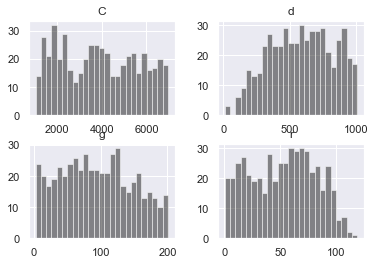

In [53]:
from pyabc.visualization import plot_kde_matrix

df, w = history.get_distribution(m=0)
#plot_kde_matrix(df, w);
df.hist(color='k', alpha=0.5, bins=25)

df.describe()

# Plot some predicted curves against experimental data

First pairwise plots

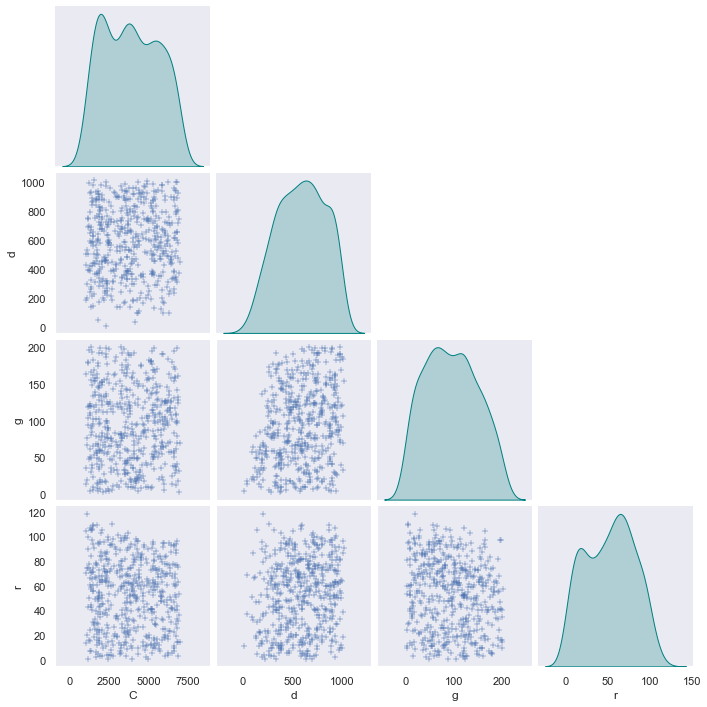

In [54]:
import seaborn as sns
sns.set(style="dark")
sns.pairplot(df, 
markers="+",
                 diag_kind="kde",
corner=True,
diag_kws= {'color': '#008080'})



Individual trajectories based on best 50 runs

ValueError: operands could not be broadcast together with shapes (500,3,1) (500,1) 

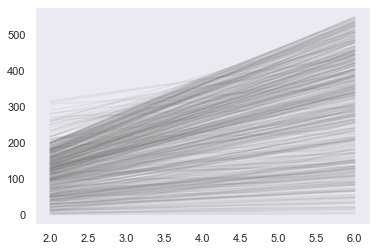

In [55]:
_, ax = plt.subplots()


def plot_data(sum_stat, weight, ax, **kwargs):
    """Plot a single trajectory"""
    ax.plot(measurement_times, sum_stat['Contamination'], color='grey', alpha=0.1)


def plot_mean(sum_stats, weights, ax, **kwargs):
    """Plot mean over all samples"""
    weights = np.array(weights)
    weights /= weights.sum()
    data = np.array([sum_stat['Contamination'] for sum_stat in sum_stats])
    mean = (data * weights.reshape((-1, 1))).sum(axis=0)
    ax.plot(measurement_times, mean, color='C2', label='Sample mean')


ax = plot_data_callback(history, plot_data, plot_mean, ax=ax)

#plt.plot(true_trajectory, color="C0", label='Simulation')
plt.scatter(measurement_times, measurement_data, color="C1", label='Data')
plt.xlabel('Time $t$')
plt.ylabel('Measurement $Y$')
plt.title('Conversion reaction: Simulated data fit')
plt.legend()
plt.show()

In [59]:
import pandas as pd

plt.errorbar(x=pd.concat([0,measurement_times]), y=pd.concat([initial_contamination,measurement_data]), yerr=pd.concat([385,sd]), fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);

TypeError: cannot concatenate object of type '<class 'int'>'; only Series and DataFrame objs are valid

In [70]:

measurement_data.insert(0,1200)

AttributeError: 'numpy.ndarray' object has no attribute 'insert'